In [26]:
import numpy as np
import pandas as pd
import json
import time
import requests
import tqdm

from os import listdir
from os.path import isfile, join


from IPython.display import clear_output
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
files = [f for f in listdir('data')]

In [17]:
files[:2]

['notify.json.2019-11-08-01-00', 'notify.json.2019-11-07-04-56']

In [19]:
# with open('data/sample', 'r') as f:
#     data = json.load(f)

In [247]:
len(data)

22333

In [154]:
data[0]['notifications'][0]['timestamp']

1573642571042

In [20]:
# data[0]

In [3]:
def parse_item(j):
    mac = j['notifications'][0]['apMacAddress']
    x = float(j['notifications'][0]['locationCoordinate']['x'])
    y = float(j['notifications'][0]['locationCoordinate']['y'])
    z = int(j['notifications'][0]['hierarchyDetails']['floor']['name'].replace('krs', '').replace(' ', '').replace('-', ''))
    event_id = j['notifications'][0]['eventId']
    latitude = float(j['notifications'][0]['geoCoordinate']['latitude'])
    longitude = float(j['notifications'][0]['geoCoordinate']['longitude'])
    timestamp = int(j['notifications'][0]['timestamp'])
    confidence = float(j['notifications'][0]['confidenceFactor'])
    return [
        x,  # 0
        y,  # 1
        z,  # 2
        latitude,  # 3
        longitude,  # 4
        timestamp,  # 5
        mac,  # 6
        event_id,  # 7
        confidence  # 8
    ]

In [157]:
len(items)

21823

In [216]:
items = np.array([parse_item(it) for it in data],dtype=np.object)

In [217]:
items[:10]

array([[380.32385, 333.56467, 1, 60.18489719517191, 24.825142822317467,
        1573642571042, 'NOT APPLICABLE', 57311317, 48.0],
       [72.48883, 42.206573, 0, 60.1858761237209, 24.823802453156436,
        1573642582358, 'NOT APPLICABLE', 57311388, 32.0],
       [225.55711, 34.464554, 3, 60.185819262560535, 24.825263353034796,
        1573642582359, '', 57311393, 24.0],
       [39.48215, 36.15173, 1, 60.18611200881109, 24.822981198152767,
        1573642604156, 'NOT APPLICABLE', 57311436, 24.0],
       [229.67174, 124.22657, 3, 60.18559609266377, 24.825035911795247,
        1573642604154, '', 57311433, 72.0],
       [2.788714, 76.9685, 2, 60.18590834344036, 24.823164495869698,
        1573642617279, '', 57311465, 80.0],
       [385.38284, 379.80267, 1, 60.18478323369787, 24.82503274531032,
        1573642634053, '', 57311520, 64.0],
       [386.20258, 379.63013, 1, 60.18478243803253, 24.825037020647112,
        1573642634042, 'NOT APPLICABLE', 57311507, 64.0],
       [34.34675, 13.85

In [160]:
len(pd.DataFrame(items).groupby([5,6]))

22294

In [8]:
my_pos = [60.185400, 24.824797]

In [4]:
def merge_chains(history):
    paths = defaultdict(list)
    last_ts = defaultdict(int)
    path_id = defaultdict(int)
    for it in history:
        mac = it[6]
        ts = it[5]
        assert ts >= last_ts[mac]
        if ts - last_ts[mac] > 10 * 1000:
            path_id[mac] += 1
        last_ts[mac] = ts
        paths[(mac, path_id[mac])].append(it)
    return paths

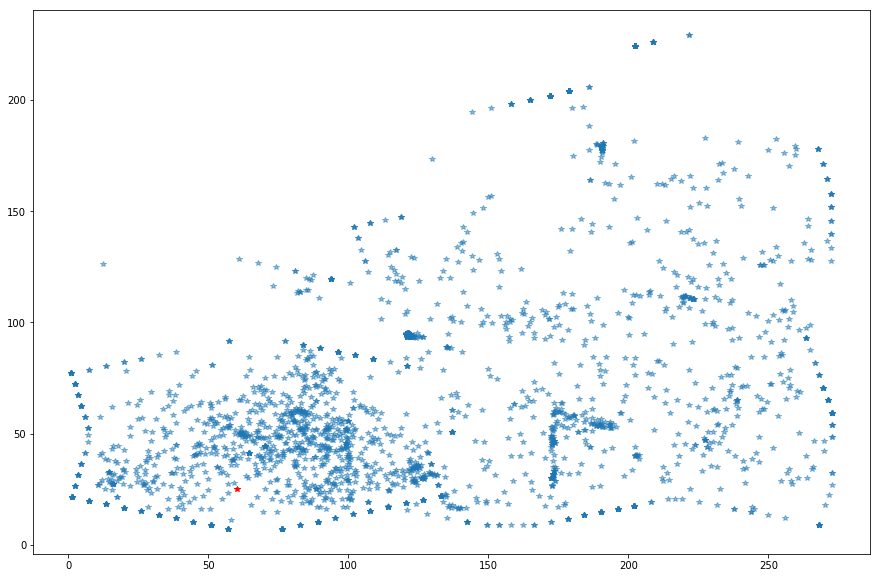

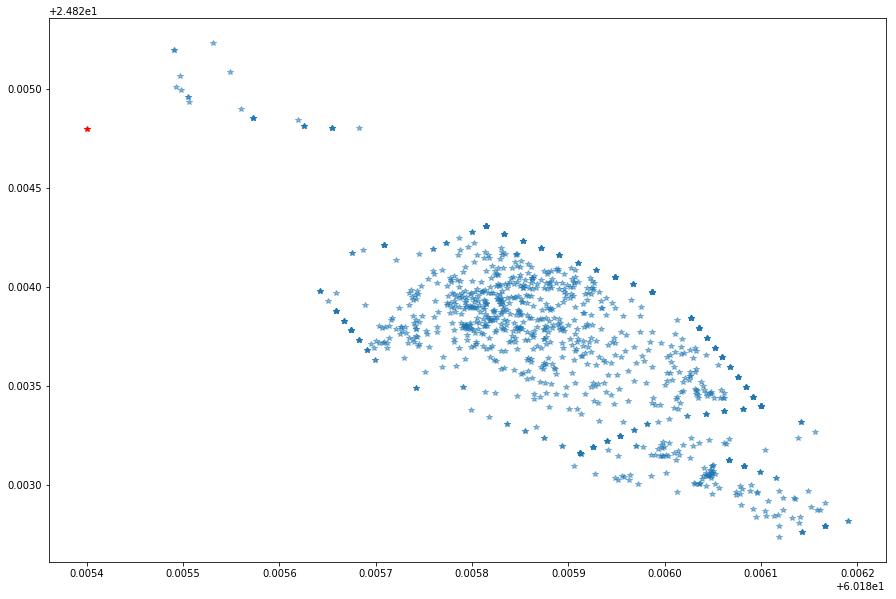

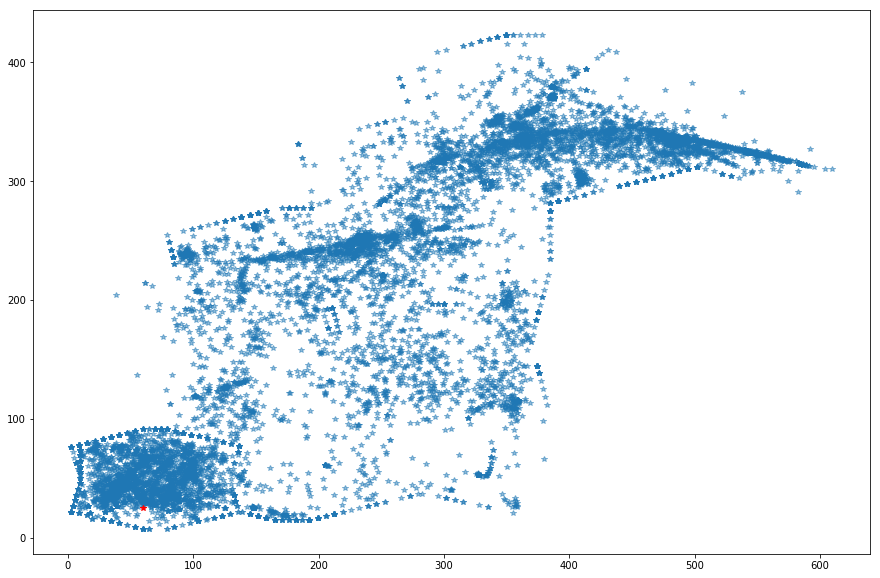

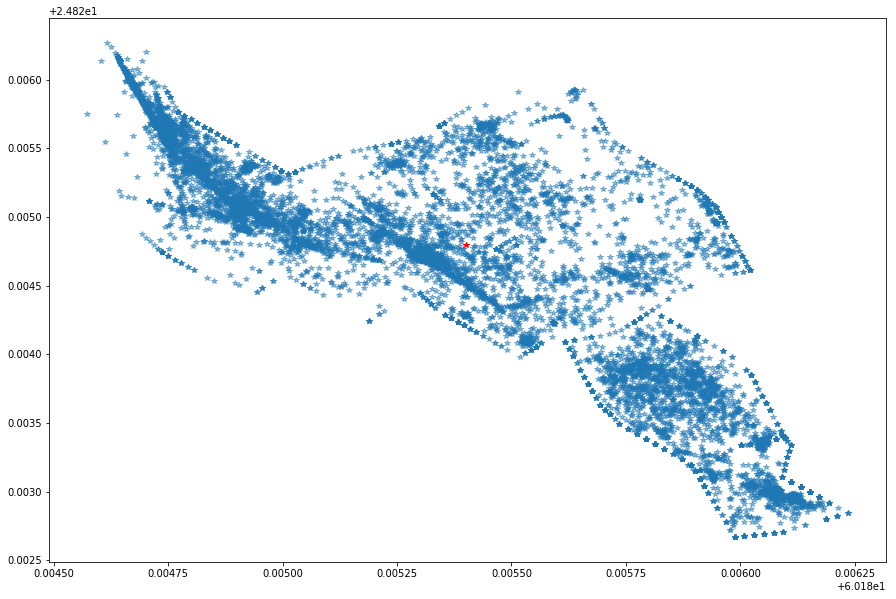

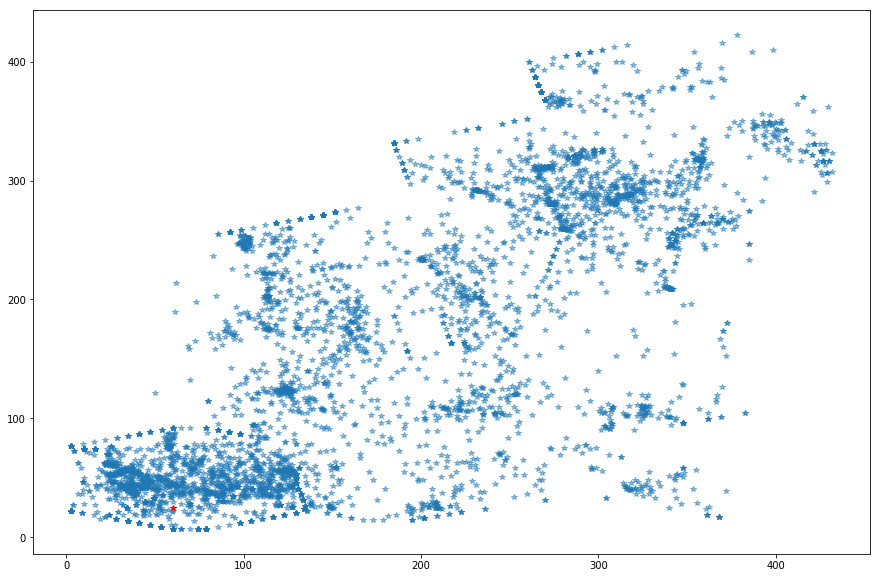

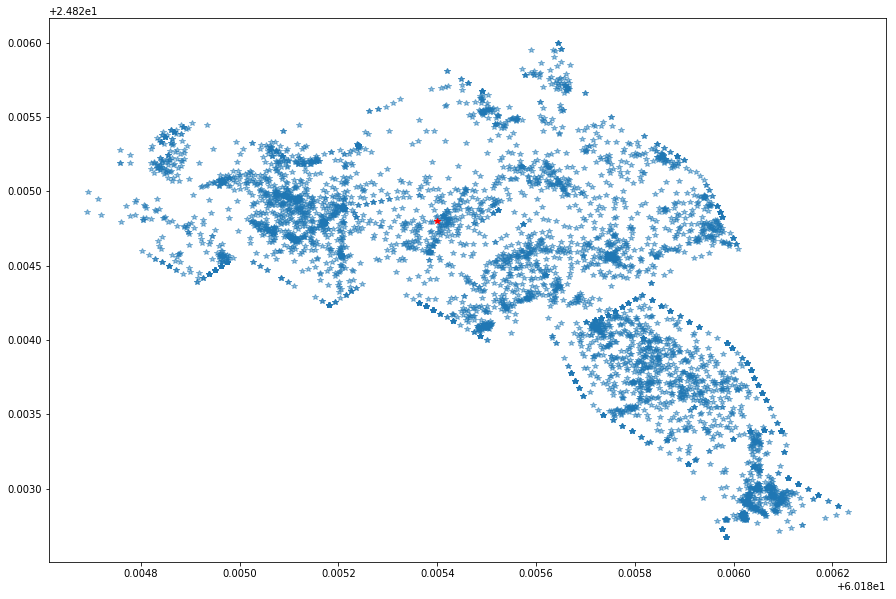

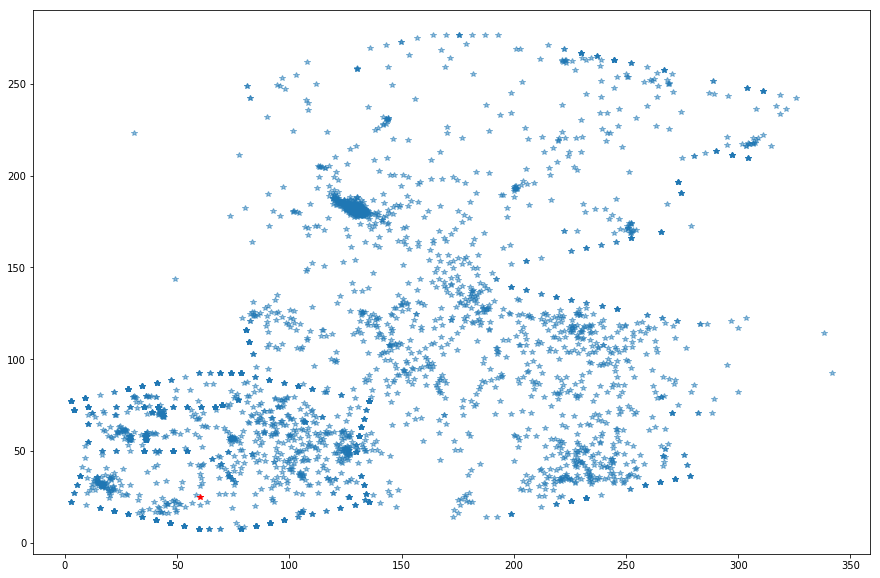

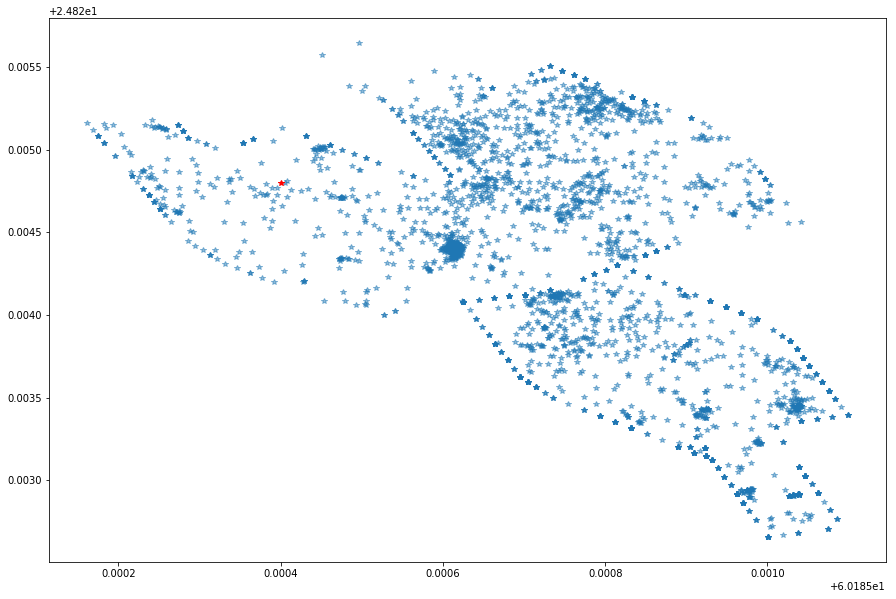

In [219]:
for f in [0,1,2,3]:
    floor = np.array([x for x in items if x[2] == f])
    plt.figure(figsize=(15,10))
    plt.plot(floor[:, 0], floor[:, 1], '*', alpha=0.5)
    plt.plot([my_pos[0]], [my_pos[1]], '*', color='red')
    plt.show()
    filtred_geo = np.array([x[[3,4]] for x in floor if x[3] > 0 and x[4] > 0])
    plt.figure(figsize=(15,10))
    plt.plot(filtred_geo[:, 0], filtred_geo[:, 1], '*', alpha=0.5)
    plt.plot([my_pos[0]], [my_pos[1]], '*', color='red')
    plt.show()

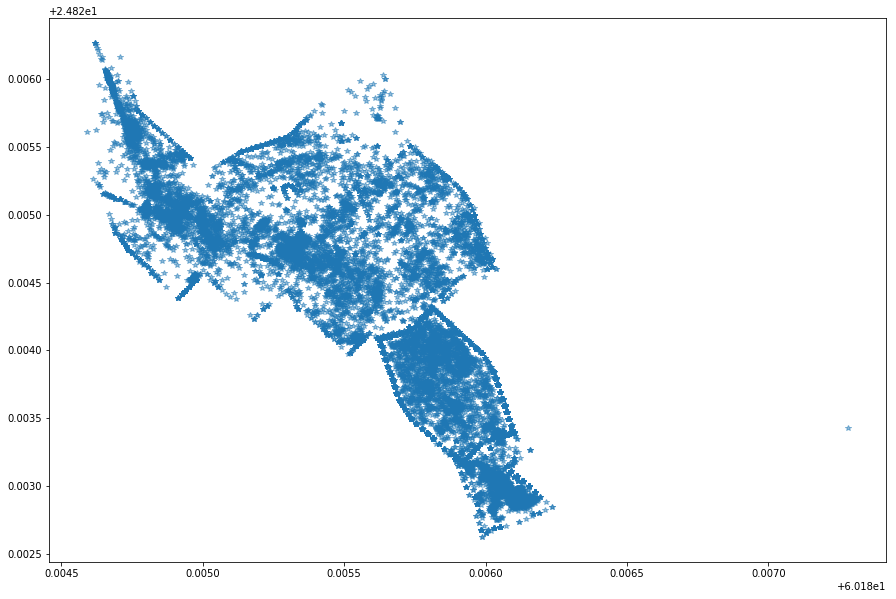

In [77]:
plt.figure(figsize=(15,10))
plt.plot(filtred_geo[:, 0], filtred_geo[:, 1], '*', alpha=0.5)
plt.show()

In [81]:
not_filtred_geo[0]

array([202.52625, 224.1798, 0, -999.0, -999.0, 1573151539765,
       'NOT APPLICABLE', 50094943], dtype=object)

In [84]:
set(items[:, 2])

{0, 1, 2, 3}

In [93]:
merge_chains(items)

In [220]:
paths = merge_chains(filter(lambda x: x[3] > 0 and x[4] > 0 and len(x[6]) > 0, sorted(items, key=lambda x : x[5])))

In [221]:
len(paths)

6467

In [21]:
def looks_bad(path):
    for i,p in enumerate(path[:-1]):
        if abs(p[3] - path[i+1][3]) > 0.00025 or abs(p[4] - path[i+1][4]) > 0.001:
            return True
    return False

def filter_f(x):
    return x[3] > 0 and 24.830 > x[4] > 0 and len(x[6]) > 0 and x[6] != 'NOT APPLICABLE'

In [22]:
filtred_paths = []

plt.figure(figsize=(30,10))
cnt = 0
lens = 0
i = 0

for file in files:
    print(file)
    with open('data/{}'.format(file), 'r') as f:
        data = json.load(f)
    print('ok')
    items = np.array([parse_item(it) for it in data],dtype=np.object)
    paths = merge_chains(filter(filter_f, sorted(items, key=lambda x : x[5])))
    for m in paths:
        if len(paths[m]) < 3 or looks_bad(paths[m]):
            continue
        plt.plot([x[3] for x in paths[m]], [x[4] for x in paths[m]], '*-', alpha=0.5)
        cnt += 1
        lens += len(paths[m])
        filtred_paths.append((m, paths[m]))

plt.show()

print(cnt, lens / cnt)

In [6]:
def try_fix(line):
    line = line.strip()
    if line[-1] == ',':
        line = line[:-1]
    if line[0] == '{':
        line = '[\n' + line
    if line[-1] == '}':
        line = line + ']'
    if line[:4] == '[\n[\n':
        line = line[2:]
    return line.replace(']\n[\n', ',\n').replace(']\n{', ',\n{').replace('}{', '}\n{').replace('}\n{', '},\n{')

In [149]:
requests.get("http://13.48.149.61:8000/notify.json",verify=False).content

b'{"notifications": [{"associated": true, "notificationType": "locationupdate", "entity": "WIRELESS_CLIENTS", "lastSeen": "2019-11-16T14:42:07.530+0200", "locationMapHierarchy": "Otaniemi>Ekonominaukio>0krs", "eventId": 8834927, "maxDetectedRssi": {"slot": 0, "band": "IEEE_802_11_B", "apMacAddress": "f4:db:e6:86:e5:a0", "rssi": -49, "lastHeardInSeconds": 6, "antennaIndex": 0}, "floorRefId": "-9013405199015870042", "ssid": "eduroam", "floorId": "-9013405199015870042", "locationCoordinate": {"y": 24.167488, "x": 83.658875, "z": 0.0, "unit": "FEET"}, "bleTagInfo": null, "username": "", "rawLocation": {"rawX": -999.0, "rawY": -999.0, "unit": "FEET"}, "timestamp": 1573908127530, "band": "IEEE_802_11_B", "deviceId": "00:00:34:26:26:0f", "subscriptionName": "Junc2", "manufacturer": "Unknown", "rssiEntries": [{"slot": 0, "lastHeardSecs": 6, "band": "IEEE_802_11_B", "apMacAddress": "f4:db:e6:86:e5:a0", "rssi": -49, "antennaIndex": 0}, {"slot": 0, "lastHeardSecs": 6, "band": "IEEE_802_11_B", "ap

In [304]:
paths = defaultdict(list)
ticks = 0
delta = 0.1
raw = np.empty(dtype=np.object, shape=(0, 9))
while True:
    ticks += 1
    time.sleep(delta)
    if ticks % (10 * 2) == 0:
        clear_output()
        plt.figure(figsize=(30,15))
        for m in paths:
            plt.plot([x[3] for x in paths[m]], [x[4] for x in paths[m]], '.-', alpha=0.5)
        plt.scatter([my_pos[0]], [my_pos[1]],s=[500],color='red')
        plt.xticks([])
        plt.yticks([])
        plt.show()
#     if ticks % (10 * 60 * 10) == 0:
#         np.save('raw/raw_{}'.format(ticks), raw)
#         np.save('raw/paths_{}'.format(ticks), paths)
#         raw = np.empty(dtype=np.object, shape=(0, 9))
#         paths =  defaultdict(list)
    try:
        r = requests.get("http://13.48.149.61:8000/notifycache.json",verify=False)
#         print(try_fix(r.content.decode('utf-8')))
        s = json.loads(try_fix(r.content.decode('utf-8')))
#         print(len(s))
        items = np.array([parse_item(x) for x in s], dtype=np.object)
        raw = np.concatenate([raw,items], axis=0)
        for it in items:
            if filter_f(it):
                paths[it[6]].append(it)
    except Exception as e:
#         pass
        print(e)
#         l = r.content.decode('utf-8')
#         print(l)
#         print('*******************')
#         print(try_fix(l))
#         break

KeyboardInterrupt: 

In [ ]:
np.load(raws)

In [19]:
raws = np.empty((0,9),dtype=np.object)

for num in [6000, 12000, 18000]:
    raw = np.load('raw/raw_{}.npy'.format(num), allow_pickle=True)
    raws = np.concatenate([raws, raw], axis=0)

In [20]:
raws.shape

(519902, 9)

In [ ]:
# filtred_paths = []

# plt.figure(figsize=(30,10))
# cnt = 0
# lens = 0
# i = 0

# paths = merge_chains(filter(filter_f, sorted(raws, key=lambda x : x[5])))
# for m in tqdm.tqdm(paths, position=0):
#     if len(paths[m]) < 3 or looks_bad(paths[m]):
#         continue
#     plt.plot([x[3] for x in paths[m]], [x[4] for x in paths[m]], '*-', alpha=0.5)
#     cnt += 1
#     lens += len(paths[m])
#     filtred_paths.append((m, paths[m]))

# plt.scatter([my_pos[0]], [my_pos[1]],s=[500],color='red')
# plt.show()

# print(cnt, lens / cnt)

In [28]:
np.save('data/filted_paths', filtred_paths)

In [204]:
N = len(filtred_paths)
train = filtred_paths[: int(N * 0.9)]
test = filtred_paths[int(N * 0.9):]

In [40]:
np.array(filtred_paths[0][1]).shape

(42, 9)

In [268]:
def prepare_dataset(_paths, size=4, horizont_msec=10 * 1000):
    X = np.empty((0, (2 * size - 1) * 3))
    Y = np.empty((0, 6))  # next_pos_x, next_pos_y, next_pos_z, next_speed_x, next_speed_y, next_speed_z
    W = np.empty(0)
    for _path in tqdm.tqdm(_paths, position=0):
        p = np.array(_path[1], dtype=np.object)
        if len(p) <= size:
            continue
        samples = []
        labels = []
        weights = []
        next_id = 0
        for i in range(len(p) - size):
            curp = p[i:i + size]
            while next_id < len(p) and  p[next_id][5] < curp[-1][5] + horizont_msec:
                next_id += 1
            if next_id == len(p):
                break
            nextp = p[next_id]
            sample =  curp[:, np.array([3,4,2])]
            conf = curp[-1][8]
            label = nextp[np.array([3,4,2])]
            ts = curp[:, 5].reshape(-1, 1)
            vel = (sample[1:] - sample[:-1]) / (ts[1:] - ts[:-1] + 1e-9) * (ts[1:] - ts[:-1] > 1e-9)
            t0 = nextp[5]
            v_next = (sample[-1] - label) / (t0 - ts[-1] + 1e-9) * (t0 - ts[-1] > 1e-9)
            samples.append(np.concatenate([sample.reshape(-1), vel.reshape(-1)]))
            labels.append(np.concatenate([label, v_next]))
            weights.append(conf)
        if len(samples) > 0:
            X = np.concatenate([X, samples], axis=0)
            Y = np.concatenate([Y, labels], axis=0)
            W = np.concatenate([W, weights], axis=0)
    return X, Y, W

In [269]:
X_train, Y_train, W_train = prepare_dataset(train)

100%|██████████| 11139/11139 [00:08<00:00, 1364.47it/s]


In [270]:
X_test, Y_test, _ = prepare_dataset(test)

100%|██████████| 1238/1238 [00:00<00:00, 3488.26it/s]


In [271]:
X_train.shape

(32560, 21)

In [272]:
Y_train.shape

(32560, 6)

In [239]:
X_test.shape

(3349, 25)

In [219]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [279]:
def run_model():
    model = KNeighborsRegressor(n_neighbors=100, weights='distance', n_jobs=4, p=1,leaf_size=100)
#     model = MLPRegressor(
#         hidden_layer_sizes=(128, 128, 128), 
#         learning_rate='invscaling', verbose=True, random_state=123, learning_rate_init=1e-2, max_iter=520, warm_start=True, tol=-100)

    X_normalizer = StandardScaler()
    Y_normalizer = StandardScaler()

    model.fit(X_normalizer.fit_transform(X_train), Y_normalizer.fit_transform(Y_train))

    Y_test_pred = Y_normalizer.inverse_transform(model.predict(X_normalizer.transform(X_test)))

    s = np.mean(np.abs(Y_test_pred[:, :2] - np.array(Y_test)[:, :2]))
    return s, model, X_normalizer, Y_normalizer

In [280]:
s, model, X_normalizer, Y_normalizer = run_model()
print(s)

0.00010612611593420482


In [281]:
def predict_with_model(x):
    return Y_normalizer.inverse_transform(model.predict(X_normalizer.transform(x)))

In [282]:
import pickle

In [302]:
with open('data/model_KNN_100_L1.pickle','wb') as f:
    pickle.dump([X_normalizer, Y_normalizer, model], f)

In [293]:
np.save('data/model_KNN_100_L1.npy', [predict_with_model])

In [294]:
f = np.load('data/model_KNN_100_L1.npy', allow_pickle=True)

In [298]:
f[0](np.zeros((1,21)))

array([[ 6.01848241e+01,  2.48250582e+01,  1.00000000e+00,
        -3.15033882e-09, -2.18051195e-08, -1.05879118e-22]])

In [159]:
# Y_test_pred = Y_normalizer.inverse_transform(model.predict(X_normalizer.transform(X_test)))

In [212]:
Y_test_pred.shape

(3146, 6)

0.00013975031734673055

In [144]:
np.std(np.array(Y_val, dtype=float), axis=0)

array([2.02166158e-04, 4.94757299e-04, 8.52640386e-01, 7.14560446e-09,
       1.92667851e-08, 5.51760850e-05])

In [145]:
filtred_paths[0][1][:2]

[array([117.880356, 39.427227, 0, 60.18578778690214, 24.82412834249375,
        1573912617582, 'f4:db:e6:86:a0:e0', 9964350, 24.0], dtype=object),
 array([117.880356, 39.427227, 0, 60.18578778690214, 24.82412834249375,
        1573912617582, 'f4:db:e6:86:a0:e0', 9964350, 24.0], dtype=object)]

In [128]:
dt = 0
cnt = 0
for _p in filtred_paths:
    p = np.array(_p[1])
    if len(p) < 2:
        continue
    for l,r in zip(p[:-1], p[1:]):
        dt += r[5] - l[5]
        cnt += 1
print(dt / cnt / 1000)

0.12651623831406594


In [147]:
np.mean(np.abs(Y_test_pred[:, :2] - np.array(Y_test)[:, :2]))

0.00013272301662550402